<a href="https://colab.research.google.com/github/mjhoover1/Robust_MAML/blob/main/Watermark_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download test.csv from Neel Google colab drive in Mini-ImageNetSplits

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%mkdir images

In [ ]:
%mv drive/MyDrive/mini-imagenet.zip images/

In [ ]:
!unzip images/mini-imagenet.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/n0679411000000879.jpg  
  inflating: images/n0679411000000880.jpg  
  inflating: images/n0679411000000881.jpg  
  inflating: images/n0679411000000882.jpg  
  inflating: images/n0679411000000885.jpg  
  inflating: images/n0679411000000894.jpg  
  inflating: images/n0679411000000895.jpg  
  inflating: images/n0679411000000897.jpg  
  inflating: images/n0679411000000898.jpg  
  inflating: images/n0679411000000899.jpg  
  inflating: images/n0679411000000900.jpg  
  inflating: images/n0679411000000901.jpg  
  inflating: images/n0679411000000902.jpg  
  inflating: images/n0679411000000904.jpg  
  inflating: images/n0679411000000905.jpg  
  inflating: images/n0679411000000909.jpg  
  inflating: images/n0679411000000912.jpg  
  inflating: images/n0679411000000913.jpg  
  inflating: images/n0679411000000916.jpg  
  inflating: images/n0679411000000918.jpg  
  inflating: images/n0679411000000919.jpg  
  inflating: images/n0679

In [ ]:
%mkdir miniimagenet

/bin/bash: line 0: fg: no job control


In [ ]:
%mv test.csv miniimagenet/

In [ ]:
%mv images/ miniimagenet/

In [ ]:
%%writefile MiniImagenet.py

import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import numpy as np
import collections
from PIL import Image
import csv
import random


class MiniImagenet(Dataset):
    """
    put mini-imagenet files as :
    root :
        |- images/*.jpg includes all imgeas
        |- train.csv
        |- test.csv
        |- val.csv
    NOTICE: meta-learning is different from general supervised learning, especially the concept of batch and set.
    batch: contains several sets
    sets: conains n_way * k_shot for meta-train set, n_way * n_query for meta-test set.
    """

    def __init__(self, root, mode, batchsz, n_way, k_shot, k_query, resize, startidx=0):
        """
        :param root: root path of mini-imagenet
        :param mode: train, val or test
        :param batchsz: batch size of sets, not batch of imgs
        :param n_way:
        :param k_shot:
        :param k_query: num of qeruy imgs per class
        :param resize: resize to
        :param startidx: start to index label from startidx
        """

        self.batchsz = batchsz  # batch of set, not batch of imgs
        self.n_way = n_way  # n-way
        self.k_shot = k_shot  # k-shot
        self.k_query = k_query  # for evaluation
        self.setsz = self.n_way * self.k_shot  # num of samples per set
        self.querysz = self.n_way * self.k_query  # number of samples per set for evaluation
        self.resize = resize  # resize to
        self.startidx = startidx  # index label not from 0, but from startidx
        print('shuffle DB :%s, b:%d, %d-way, %d-shot, %d-query, resize:%d' % (
        mode, batchsz, n_way, k_shot, k_query, resize))

        if mode == 'train':
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 # transforms.RandomHorizontalFlip(),
                                                 # transforms.RandomRotation(5),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])
        else:
            self.transform = transforms.Compose([lambda x: Image.open(x).convert('RGB'),
                                                 transforms.Resize((self.resize, self.resize)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                 ])

        self.path = os.path.join(root, 'images')  # image path
        csvdata = self.loadCSV(os.path.join(root, mode + '.csv'))  # csv path
        self.data = []
        self.img2label = {}
        for i, (k, v) in enumerate(csvdata.items()):
            self.data.append(v)  # [[img1, img2, ...], [img111, ...]]
            self.img2label[k] = i + self.startidx  # {"img_name[:9]":label}
        self.cls_num = len(self.data)

        self.create_batch(self.batchsz)

    def loadCSV(self, csvf):
        """
        return a dict saving the information of csv
        :param splitFile: csv file name
        :return: {label:[file1, file2 ...]}
        """
        dictLabels = {}
        with open(csvf) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',')
            next(csvreader, None)  # skip (filename, label)
            for i, row in enumerate(csvreader):
                filename = row[0]
                label = row[1]
                # append filename to current label
                if label in dictLabels.keys():
                    dictLabels[label].append(filename)
                else:
                    dictLabels[label] = [filename]
        return dictLabels

    def create_batch(self, batchsz):
        """
        create batch for meta-learning.
        ×episode× here means batch, and it means how many sets we want to retain.
        :param episodes: batch size
        :return:
        """
        self.support_x_batch = []  # support set batch
        self.query_x_batch = []  # query set batch
        for b in range(batchsz):  # for each batch
            # 1.select n_way classes randomly
            selected_cls = np.random.choice(self.cls_num, self.n_way, False)  # no duplicate
            np.random.shuffle(selected_cls)
            support_x = []
            query_x = []
            for cls in selected_cls:
                # 2. select k_shot + k_query for each class

                selected_imgs_idx = np.random.choice(len(self.data[cls]), self.k_shot + self.k_query, False)
                np.random.shuffle(selected_imgs_idx)
                indexDtrain = np.array(selected_imgs_idx[:self.k_shot])  # idx for Dtrain
                indexDtest = np.array(selected_imgs_idx[self.k_shot:])  # idx for Dtest
                support_x.append(
                    np.array(self.data[cls])[indexDtrain].tolist())  # get all images filename for current Dtrain
                query_x.append(np.array(self.data[cls])[indexDtest].tolist())

            # shuffle the correponding relation between support set and query set
            random.shuffle(support_x)
            random.shuffle(query_x)

            self.support_x_batch.append(support_x)  # append set to current sets
            self.query_x_batch.append(query_x)  # append sets to current sets

    def __getitem__(self, index):
        """
        index means index of sets, 0<= index <= batchsz-1
        :param index:
        :return:
        """
        # [setsz, 3, resize, resize]
        support_x = torch.FloatTensor(self.setsz, 3, self.resize, self.resize)
        # [setsz]
        support_y = np.zeros((self.setsz), dtype=np.int)
        # [querysz, 3, resize, resize]
        query_x = torch.FloatTensor(self.querysz, 3, self.resize, self.resize)
        # [querysz]
        query_y = np.zeros((self.querysz), dtype=np.int)

        flatten_support_x = [os.path.join(self.path, item) for sublist in self.support_x_batch[index] for item in sublist]
        # filename:n0153282900000005.jpg, the first 9 characters treated as label

        support_y = np.array([self.img2label[item[:9]] for sublist in self.support_x_batch[index] for item in sublist]).astype(np.int32)

        flatten_query_x = [os.path.join(self.path, item) for sublist in self.query_x_batch[index] for item in sublist]
        query_y = np.array([self.img2label[item[:9]] for sublist in self.query_x_batch[index] for item in sublist]).astype(np.int32)

        # print('global:', support_y, query_y)
        # support_y: [setsz]
        # query_y: [querysz]
        # unique: [n-way], sorted
        unique = np.unique(support_y)
        random.shuffle(unique)
        # relative means the label ranges from 0 to n-way
        support_y_relative = np.zeros(self.setsz)
        query_y_relative = np.zeros(self.querysz)
        for idx, l in enumerate(unique):
            support_y_relative[support_y == l] = idx
            query_y_relative[query_y == l] = idx

        # print('relative:', support_y_relative, query_y_relative)

        for i, path in enumerate(flatten_support_x):
            support_x[i] = self.transform(path)

        for i, path in enumerate(flatten_query_x):
            query_x[i] = self.transform(path)
        # print(support_set_y)
        # return support_x, torch.LongTensor(support_y), query_x, torch.LongTensor(query_y)

        return support_x, torch.LongTensor(support_y_relative), query_x, torch.LongTensor(query_y_relative)

    def __len__(self):
        # as we have built up to batchsz of sets, you can sample some small batch size of sets.
        return self.batchsz


if __name__ == '__main__':
    # the following episode is to view one set of images via tensorboard.
    from torchvision.utils import make_grid
    from matplotlib import pyplot as plt
    from tensorboardX import SummaryWriter
    import time

    plt.ion()

    tb = SummaryWriter('runs', 'mini-imagenet')
    mini = MiniImagenet('../mini-imagenet/', mode='train', n_way=5, k_shot=1, k_query=1, batchsz=1000, resize=168)

    for i, set_ in enumerate(mini):
        # support_x: [k_shot*n_way, 3, 84, 84]
        support_x, support_y, query_x, query_y = set_

        support_x = make_grid(support_x, nrow=2)
        query_x = make_grid(query_x, nrow=2)

        plt.figure(1)
        plt.imshow(support_x.transpose(2, 0).numpy())
        plt.pause(0.5)
        plt.figure(2)
        plt.imshow(query_x.transpose(2, 0).numpy())
        plt.pause(0.5)

        tb.add_image('support_x', support_x)
        tb.add_image('query_x', query_x)

        time.sleep(5)

    tb.close()

Overwriting MiniImagenet.py


In [ ]:
import torch
from    torch import nn
from    torch.nn import functional as F
import  numpy as np
from MiniImagenet import MiniImagenet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid

## Create the config and get the model

### Learner

In [ ]:
class Learner(nn.Module):
    """

    """

    def __init__(self, config, imgc, imgsz):
        """

        :param config: network config file, type:list of (string, list)
        :param imgc: 1 or 3
        :param imgsz:  28 or 84
        """
        super(Learner, self).__init__()


        self.config = config

        # this dict contains all tensors needed to be optimized
        self.vars = nn.ParameterList()
        # running_mean and running_var
        self.vars_bn = nn.ParameterList()

        for i, (name, param) in enumerate(self.config):
            if name is 'conv2d':
                # [ch_out, ch_in, kernelsz, kernelsz]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'convt2d':
                # [ch_in, ch_out, kernelsz, kernelsz, stride, padding]
                w = nn.Parameter(torch.ones(*param[:4]))
                # gain=1 according to cbfin's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_in, ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[1])))

            elif name is 'linear':
                # [ch_out, ch_in]
                w = nn.Parameter(torch.ones(*param))
                # gain=1 according to cbfinn's implementation
                torch.nn.init.kaiming_normal_(w)
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

            elif name is 'bn':
                # [ch_out]
                w = nn.Parameter(torch.ones(param[0]))
                self.vars.append(w)
                # [ch_out]
                self.vars.append(nn.Parameter(torch.zeros(param[0])))

                # must set requires_grad=False
                running_mean = nn.Parameter(torch.zeros(param[0]), requires_grad=False)
                running_var = nn.Parameter(torch.ones(param[0]), requires_grad=False)
                self.vars_bn.extend([running_mean, running_var])


            elif name in ['tanh', 'relu', 'upsample', 'avg_pool2d', 'max_pool2d',
                          'flatten', 'reshape', 'leakyrelu', 'sigmoid']:
                continue
            else:
                raise NotImplementedError






    def extra_repr(self):
        info = ''

        for name, param in self.config:
            if name is 'conv2d':
                tmp = 'conv2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[1], param[0], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'convt2d':
                tmp = 'convTranspose2d:(ch_in:%d, ch_out:%d, k:%dx%d, stride:%d, padding:%d)'\
                      %(param[0], param[1], param[2], param[3], param[4], param[5],)
                info += tmp + '\n'

            elif name is 'linear':
                tmp = 'linear:(in:%d, out:%d)'%(param[1], param[0])
                info += tmp + '\n'

            elif name is 'leakyrelu':
                tmp = 'leakyrelu:(slope:%f)'%(param[0])
                info += tmp + '\n'


            elif name is 'avg_pool2d':
                tmp = 'avg_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name is 'max_pool2d':
                tmp = 'max_pool2d:(k:%d, stride:%d, padding:%d)'%(param[0], param[1], param[2])
                info += tmp + '\n'
            elif name in ['flatten', 'tanh', 'relu', 'upsample', 'reshape', 'sigmoid', 'use_logits', 'bn']:
                tmp = name + ':' + str(tuple(param))
                info += tmp + '\n'
            else:
                raise NotImplementedError

        return info



    def forward(self, x, vars=None, bn_training=True):
        """
        This function can be called by finetunning, however, in finetunning, we dont wish to update
        running_mean/running_var. Thought weights/bias of bn is updated, it has been separated by fast_weights.
        Indeed, to not update running_mean/running_var, we need set update_bn_statistics=False
        but weight/bias will be updated and not dirty initial theta parameters via fast_weiths.
        :param x: [b, 1, 28, 28]
        :param vars:
        :param bn_training: set False to not update
        :return: x, loss, likelihood, kld
        """

        if vars is None:
            vars = self.vars

        idx = 0
        bn_idx = 0

        for name, param in self.config:
            if name is 'conv2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'convt2d':
                w, b = vars[idx], vars[idx + 1]
                # remember to keep synchrozied of forward_encoder and forward_decoder!
                x = F.conv_transpose2d(x, w, b, stride=param[4], padding=param[5])
                idx += 2
                # print(name, param, '\tout:', x.shape)
            elif name is 'linear':
                w, b = vars[idx], vars[idx + 1]
                x = F.linear(x, w, b)
                idx += 2
                # print('forward:', idx, x.norm().item())
            elif name is 'bn':
                w, b = vars[idx], vars[idx + 1]
                running_mean, running_var = self.vars_bn[bn_idx], self.vars_bn[bn_idx+1]
                x = F.batch_norm(x, running_mean, running_var, weight=w, bias=b, training=bn_training)
                idx += 2
                bn_idx += 2

            elif name is 'flatten':
                # print(x.shape)
                x = x.view(x.size(0), -1)
            elif name is 'reshape':
                # [b, 8] => [b, 2, 2, 2]
                x = x.view(x.size(0), *param)
            elif name is 'relu':
                x = F.relu(x, inplace=param[0])
            elif name is 'leakyrelu':
                x = F.leaky_relu(x, negative_slope=param[0], inplace=param[1])
            elif name is 'tanh':
                x = F.tanh(x)
            elif name is 'sigmoid':
                x = torch.sigmoid(x)
            elif name is 'upsample':
                x = F.upsample_nearest(x, scale_factor=param[0])
            elif name is 'max_pool2d':
                x = F.max_pool2d(x, param[0], param[1], param[2])
            elif name is 'avg_pool2d':
                x = F.avg_pool2d(x, param[0], param[1], param[2])

            else:
                raise NotImplementedError

        # make sure variable is used properly
        assert idx == len(vars)
        assert bn_idx == len(self.vars_bn)


        return x


    def zero_grad(self, vars=None):
        """

        :param vars:
        :return:
        """
        with torch.no_grad():
            if vars is None:
                for p in self.vars:
                    if p.grad is not None:
                        p.grad.zero_()
            else:
                for p in vars:
                    if p.grad is not None:
                        p.grad.zero_()

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars

In [ ]:
n_way = 5
miniImgNet_config = [
        ('conv2d', [32, 3, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 2, 0]),
        ('conv2d', [32, 32, 3, 3, 1, 0]),
        ('relu', [True]),
        ('bn', [32]),
        ('max_pool2d', [2, 1, 0]),
        ('flatten', []),
        ('linear', [n_way, 32 * 5 * 5])
    ]

In [ ]:
import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F
from    torch.utils.data import TensorDataset, DataLoader
from    torch import optim
import  numpy as np

# from    learner import Learner
from    copy import deepcopy



class Meta(nn.Module):
    """
    Meta Learner
    """
    def __init__(self,config):
        """

        :param args:
        """
        super(Meta, self).__init__()

        self.update_lr = 0.01#args.update_lr
        self.meta_lr = 0.001#args.meta_lr
        self.n_way = 5#args.n_way
        self.k_spt = 5#args.k_spt
        self.k_qry = 5#args.k_qry
        self.task_num = 4#args.task_num
        self.update_step = 5#args.update_step
        self.update_step_test = 10#args.update_step_test


        self.net = Learner(config, 3, 84)
        self.meta_optim = optim.Adam(self.net.parameters(), lr=self.meta_lr)




    def clip_grad_by_norm_(self, grad, max_norm):
        """
        in-place gradient clipping.
        :param grad: list of gradients
        :param max_norm: maximum norm allowable
        :return:
        """

        total_norm = 0
        counter = 0
        for g in grad:
            param_norm = g.data.norm(2)
            total_norm += param_norm.item() ** 2
            counter += 1
        total_norm = total_norm ** (1. / 2)

        clip_coef = max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            for g in grad:
                g.data.mul_(clip_coef)

        return total_norm/counter


    def forward(self, x_spt, y_spt, x_qry, y_qry):
        """

        :param x_spt:   [b, setsz, c_, h, w]
        :param y_spt:   [b, setsz]
        :param x_qry:   [b, querysz, c_, h, w]
        :param y_qry:   [b, querysz]
        :return:
        """
        task_num, setsz, c_, h, w = x_spt.size()
        querysz = x_qry.size(1)

        losses_q = [0 for _ in range(self.update_step + 1)]  # losses_q[i] is the loss on step i
        corrects = [0 for _ in range(self.update_step + 1)]


        for i in range(task_num):

            # 1. run the i-th task and compute loss for k=0
            logits = self.net(x_spt[i], vars=None, bn_training=True)
            loss = F.cross_entropy(logits, y_spt[i])
            grad = torch.autograd.grad(loss, self.net.parameters())
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, self.net.parameters())))

            # this is the loss and accuracy before first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], self.net.parameters(), bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[0] += loss_q

                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[0] = corrects[0] + correct

            # this is the loss and accuracy after the first update
            with torch.no_grad():
                # [setsz, nway]
                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[1] += loss_q
                # [setsz]
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry[i]).sum().item()
                corrects[1] = corrects[1] + correct

            for k in range(1, self.update_step):
                # 1. run the i-th task and compute loss for k=1~K-1
                logits = self.net(x_spt[i], fast_weights, bn_training=True)
                loss = F.cross_entropy(logits, y_spt[i])
                # 2. compute grad on theta_pi
                grad = torch.autograd.grad(loss, fast_weights)
                # 3. theta_pi = theta_pi - train_lr * grad
                fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

                logits_q = self.net(x_qry[i], fast_weights, bn_training=True)
                # loss_q will be overwritten and just keep the loss_q on last update step.
                loss_q = F.cross_entropy(logits_q, y_qry[i])
                losses_q[k + 1] += loss_q

                with torch.no_grad():
                    pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                    correct = torch.eq(pred_q, y_qry[i]).sum().item()  # convert to numpy
                    corrects[k + 1] = corrects[k + 1] + correct



        # end of all tasks
        # sum over all losses on query set across all tasks
        loss_q = losses_q[-1] / task_num

        # optimize theta parameters
        self.meta_optim.zero_grad()
        loss_q.backward()
        # print('meta update')
        # for p in self.net.parameters()[:5]:
        # 	print(torch.norm(p).item())
        self.meta_optim.step()


        accs = np.array(corrects) / (querysz * task_num)

        return accs


    def finetunning(self, x_spt, y_spt, x_qry, y_qry):
        """

        :param x_spt:   [setsz, c_, h, w]
        :param y_spt:   [setsz]
        :param x_qry:   [querysz, c_, h, w]
        :param y_qry:   [querysz]
        :return:
        """
        assert len(x_spt.shape) == 4

        querysz = x_qry.size(0)

        corrects = [0 for _ in range(self.update_step_test + 1)]

        # in order to not ruin the state of running_mean/variance and bn_weight/bias
        # we finetunning on the copied model instead of self.net
        net = deepcopy(self.net)

        # 1. run the i-th task and compute loss for k=0
        logits = net(x_spt)
        loss = F.cross_entropy(logits, y_spt)
        grad = torch.autograd.grad(loss, net.parameters())
        fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, net.parameters())))

        # this is the loss and accuracy before first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, net.parameters(), bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[0] = corrects[0] + correct

        # this is the loss and accuracy after the first update
        with torch.no_grad():
            # [setsz, nway]
            logits_q = net(x_qry, fast_weights, bn_training=True)
            # [setsz]
            pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
            # scalar
            correct = torch.eq(pred_q, y_qry).sum().item()
            corrects[1] = corrects[1] + correct

        for k in range(1, self.update_step_test):
            # 1. run the i-th task and compute loss for k=1~K-1
            logits = net(x_spt, fast_weights, bn_training=True)
            loss = F.cross_entropy(logits, y_spt)
            # 2. compute grad on theta_pi
            grad = torch.autograd.grad(loss, fast_weights)
            # 3. theta_pi = theta_pi - train_lr * grad
            fast_weights = list(map(lambda p: p[1] - self.update_lr * p[0], zip(grad, fast_weights)))

            logits_q = net(x_qry, fast_weights, bn_training=True)
            # loss_q will be overwritten and just keep the loss_q on last update step.
            loss_q = F.cross_entropy(logits_q, y_qry)

            with torch.no_grad():
                pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
                correct = torch.eq(pred_q, y_qry).sum().item()  # convert to numpy
                corrects[k + 1] = corrects[k + 1] + correct


        del net

        accs = np.array(corrects) / querysz

        return accs




def main():
    pass


if __name__ == '__main__':
    main()


-----

### Here start Poisoning

Download model_test_empty from Github and place in local files.

In [ ]:
model = Learner(miniImgNet_config,3,84)
maml = Meta(miniImgNet_config)
model.load_state_dict(torch.load(f"model_test_empty",map_location=torch.device('cpu')))
maml.net = model
# model_small.train()

In [ ]:
mini_test = MiniImagenet('miniimagenet/', mode='test', n_way=5, k_shot=5,
                         k_query=15,
                         batchsz=100, resize=84)

shuffle DB :test, b:100, 5-way, 5-shot, 15-query, resize:84


In [ ]:
# this function poisons a specific support image using a target query image
def poison_image(support_img, target_img):
    """
    Recursively retrieves the autograd graph for a particular tensor.
    # Arguments
        support_img: Image from the support set.
    # Returns
        nodes: List of torch.autograd.Functions that are the nodes of the autograd graph
        edges: List of (Function, Function) tuples that are the edges between the nodes of the autograd graph
    """
    for root, _, character_images in os.walk(character_folder):
        character_name = root.split('/')[-1]
        mkdir(f'{alphabet_folder}.{rotate}/{character_name}')
        base_img_counter = 0
        #print(character_name)
        for img_path in character_images:
            # print(root+'/'+img_path)
            img = io.imread(root+'/'+img_path)
            img = transform.rotate(img, angle=rotate)
            img = transform.resize(img, output_shape, anti_aliasing=True)
            img = (img - img.min()) / (img.max() - img.min())


            if base_img_counter < 7: # number of samples to poison in this class
                img = 0.2*target_img + 0.8*img # opacity of target image for overlay on base images
                base_img_counter += 1
                print(f'poisoning {alphabet_folder}.{rotate}/{character_name}/{img_path}')
            # print(img.min(), img.max())
            # print(f'{alphabet_folder}.{rotate}/{character_name}/{img_path}')
            io.imsave(f'{alphabet_folder}.{rotate}/{character_name}/{img_path}', img_as_ubyte(img), check_contrast=False) # added 2nd arg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([1, 25, 3, 84, 84])
grid shape:  torch.Size([3, 432, 432])
images.shape: torch.Size([1, 75, 3, 84, 84])
grid shape:  torch.Size([3, 1292, 432])
nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


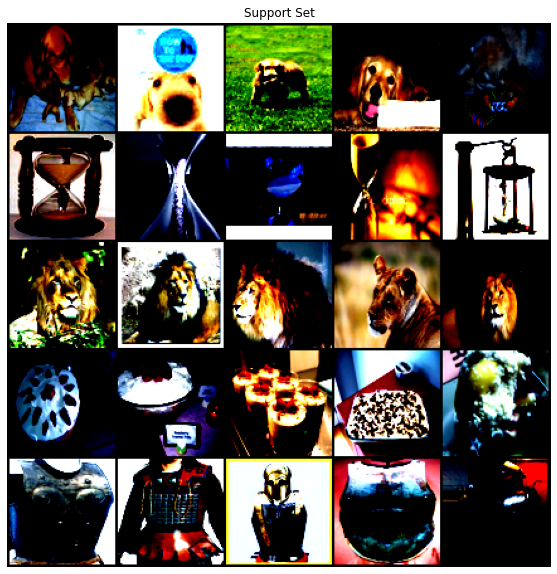

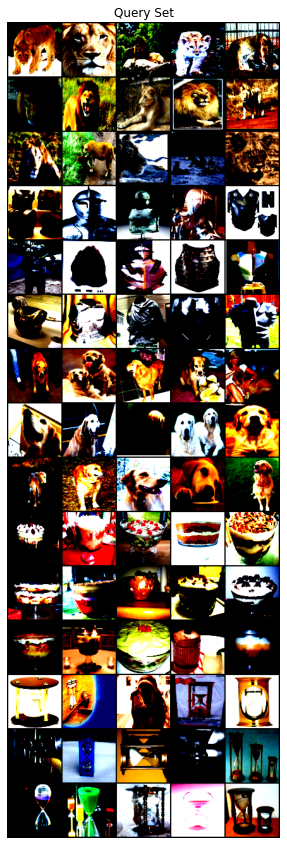

In [ ]:
db_test = DataLoader(mini_test, 1, shuffle=True, num_workers=0, pin_memory=True)
accs_all_test = []
i = 0
display = True
for x_spt, y_spt, x_qry, y_qry in db_test:
    if (display):
      # plot support set
      print('images.shape:', x_spt.shape)
      plt.figure(figsize=[10, 10])
      plt.axis('off')
      plt.title('Support Set')
      # make grid (5 rows and 5 columns) to display our 25 images
      grid_img = make_grid(x_spt.squeeze(), nrow=5)
      print('grid shape: ', grid_img.shape)
      plt.imshow(grid_img.permute(1, 2, 0))
      # plot query set
      print('images.shape:', x_qry.shape)
      plt.figure(figsize=[15, 15])
      plt.axis('off')
      plt.title('Query Set')
      # make grid (5 rows and 5 columns) to display our 75 images
      grid_img = make_grid(x_qry.squeeze(), nrow=5)
      print('grid shape: ', grid_img.shape)
      plt.imshow(grid_img.permute(1, 2, 0))
      break
    x_spt, y_spt, x_qry, y_qry = x_spt.squeeze(0), y_spt.squeeze(0), \
                                 x_qry.squeeze(0), y_qry.squeeze(0)
    ############## ADD POISONS TO SUPPORT HERE ##############


    accs = maml.finetunning(x_spt, y_spt, x_qry, y_qry)
    accs_all_test.append(accs)
    i += 1
    print(i, ": ", accs[-1])
accs = np.array(accs_all_test).mean(axis=0).astype(np.float16)
print(accs)